# Dohvat slika, smanjivanje dataseta

In [ ]:
# !pip install tqdm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import requests
from tqdm import tqdm
import os
import random
from zipfile import ZipFile
import json
import pandas as pd

In [3]:

url = "https://zenodo.org/record/10657763/files/OnlineAds.zip"

drive_folder = "/content/drive/MyDrive/UPZ PDP/projekt"
os.makedirs(drive_folder, exist_ok=True)

zip_path = os.path.join(drive_folder, "OnlineAds.zip")
selected_path = os.path.join(drive_folder, "SelectedAds.zip")

In [ ]:
# # download zipanog foldera - traje 50 minuta a cijeli folder nije potreban nakon što se izvuče sample slika
# response = requests.get(url, stream=True)
# total_size = int(response.headers.get('content-length', 0))
# chunk_size = 1024*1024

# print(f"Preuzimam OnlineAds.zip (~{total_size/1024/1024:.2f} MB) direktno na Drive...")

# with open(zip_path, "wb") as f:
#   for chunk in tqdm(response.iter_content(chunk_size=chunk_size), total=total_size//chunk_size, unit='MB'):
#     f.write(chunk)

# print(f"ZIP spremljen na Drive: {zip_path}")


In [ ]:
# with ZipFile(zip_path, 'r') as zip_ref:
#     print(zip_ref.namelist()[:20])

In [ ]:
# # selektiranje random 200 slika, raspakiravanje i trajno spremanje na disk - nije potrebno ponavljati
# json_path = os.path.join(drive_folder, "web_annot_j.json")
# with open(json_path, 'r') as f:
#   annotations = json.load(f)
# all_image_paths = ['OnlineAds/' + ann['img_path'].replace('..\\OnlineAds\\','').replace('\\','/') for ann in annotations]

# N = 200
# saved_count = 0
# attempted = set()

# with ZipFile(zip_path, 'r') as zip_ref:
#   zip_files = set(zip_ref.namelist())
#   with ZipFile(selected_path, 'w') as new_zip:
#     while saved_count < N and len(attempted) < len(all_image_paths):
#       img = random.choice(all_image_paths)
#       if img in attempted:
#         continue
#       attempted.add(img)
#       try:
#         if img in zip_files:
#           data = zip_ref.read(img)
#           new_zip.writestr(img, data)
#           saved_count += 1
#           print(f"Spremio: {img}")
#       except KeyError:
#         continue

# print(f"{saved_count} random slika uspješno spremljeno u novi ZIP: {selected_path}")

# Priprema dataseta

In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# raspakiravanje svih slika
extract_dir = "/content/selected_images"
os.makedirs(extract_dir, exist_ok=True)

records = []

with ZipFile(selected_path, 'r') as zip_ref:
  for member in zip_ref.namelist():
    if member.endswith('/'):
      continue

    original_path = member
    filename = os.path.basename(member)
    parts = original_path.split('/')
    group = parts[1] if len(parts) > 1 else "unknown"

    target_path = os.path.join(extract_dir, filename)
    with zip_ref.open(member) as source, open(target_path, "wb") as target:
      target.write(source.read())

    records.append({
      "filename": filename,
      "image_path": target_path,
      "group": group
    })

print(f"Raspakirano {len(records)} slika u {extract_dir}")

Raspakirano 200 slika u /content/selected_images


In [ ]:
# pravljenje df-a
df = pd.DataFrame(records)

df.insert(0, "id", range(len(df)))

images = []
for path in df["image_path"]:
    img = Image.open(path).convert("RGB")
    images.append(img)

df["image"] = images

df.drop(columns=["image_path"], inplace=True)

df.head()

,id,filename,group,image
0,0,ICICI_Bank_25.jpg,financial_institutions,<PIL.Image.Image image mode=RGB size=250x390 a...
1,1,Parle_G_37.jpg,food,<PIL.Image.Image image mode=RGB size=1080x1080...
2,2,Lava_Mobiles_mobiles_57.jpg,electronics,<PIL.Image.Image image mode=RGB size=1080x1350...
3,3,Ferrero_Rocher_chocolate_12.jpg,food,<PIL.Image.Image image mode=RGB size=787x443 a...
4,4,Sparx_44.jpg,body_wear,<PIL.Image.Image image mode=RGB size=1080x1079...


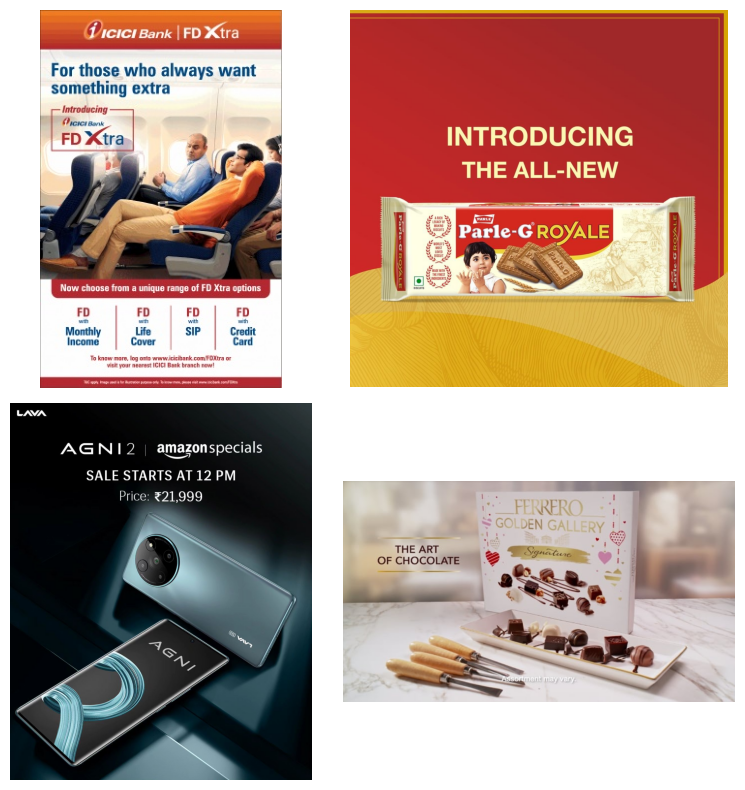

In [ ]:
plt.figure(figsize=(8, 8))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(df["image"][i])
    plt.axis("off")

plt.tight_layout()
plt.show()

# Izdvajanje značajki


In [ ]:
!pip install transformers ultralytics easyocr opencv-python-headless pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 33.3 MB/s eta 0:00:00


In [ ]:
import os
import json
import requests
from tqdm import tqdm
from zipfile import ZipFile
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from sklearn.cluster import KMeans
from collections import Counter

from transformers import CLIPProcessor, CLIPModel
from ultralytics import YOLO
import easyocr

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Semantički i komunikacijski feature

In [ ]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
def extract_clip_features(image):
    """
    Izvlači emocionalne, poručne i stilske značajke koristeći CLIP.
    Ulaz: PIL Image objekt
    """
    if image is None:
        return {}

    # Definiranje promptova
    prompts_emotion = [
        "a marketing advertisement that evokes joy and happiness",
        "a calm and reassuring advertisement image",
        "a serious and rational advertisement",
        "an exciting and energetic advertisement",
        "a sad or melancholic advertisement image"
    ]
    emotion_labels = ["joy", "calm", "serious", "exciting", "sad"]

    prompts_message = [
        "an informational advertisement focusing on product features",
        "an emotional advertisement appealing to feelings",
        "a symbolic or metaphorical advertisement",
        "a persuasive marketing advertisement"
    ]
    message_labels = ["informational", "emotional", "symbolic", "persuasive"]

    prompts_style = [
        "a minimalist advertisement design",
        "a lifestyle advertisement showing real-life context",
        "a product-focused advertisement with the product in focus",
        "a highly detailed and complex advertisement image"
    ]
    style_labels = ["minimalist", "lifestyle", "product_focused", "complex"]

    all_prompts = prompts_emotion + prompts_message + prompts_style

    inputs = clip_processor(text=all_prompts, images=image, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    probs_list = probs.cpu().numpy()[0]

    features = {}

    # --- 1.1 Emocionalni ton ---
    emotion_probs = probs_list[0:5]
    features['emotion_joy_score'] = float(emotion_probs[0])
    features['emotion_calm_score'] = float(emotion_probs[1])
    features['emotion_serious_score'] = float(emotion_probs[2])
    features['emotion_exciting_score'] = float(emotion_probs[3])
    features['emotion_sad_score'] = float(emotion_probs[4])

    max_emotion_idx = np.argmax(emotion_probs)
    features['emotion_label'] = emotion_labels[max_emotion_idx]

    # --- 1.2 Tip poruke ---
    message_probs = probs_list[5:9]
    features['message_informational_score'] = float(message_probs[0])
    features['message_emotional_score'] = float(message_probs[1])
    features['message_symbolic_score'] = float(message_probs[2])
    features['message_persuasive_score'] = float(message_probs[3])
    features['message_type'] = message_labels[np.argmax(message_probs)]

    # --- 1.3 Vizualni stil ---
    style_probs = probs_list[9:13]
    features['style_minimalist_score'] = float(style_probs[0])
    features['style_lifestyle_score'] = float(style_probs[1])
    features['style_product_score'] = float(style_probs[2])
    features['style_complex_score'] = float(style_probs[3])
    features['visual_style'] = style_labels[np.argmax(style_probs)]

    return features

### 2. Objektni i kompozicijski feature

In [ ]:
yolo_model = YOLO('yolov8n.pt')
print("YOLOv8 model učitan.")

YOLOv8 model učitan.


In [ ]:
def extract_yolo_features(image):
    """
    Izvlači objektne i kompozicijske značajke.
    Ulaz: PIL Image objekt
    """
    try:
        # YOLO podržava PIL image direktno
        results = yolo_model(image, verbose=False)
    except Exception as e:
        print(f"YOLO greška: {e}")
        return {}

    r = results[0]

    img_height, img_width = r.orig_shape
    total_img_area = img_height * img_width

    boxes = r.boxes

    person_indices = (boxes.cls == 0).nonzero(as_tuple=True)[0]

    num_people = len(person_indices)
    people_area = 0

    for idx in person_indices:
        box = boxes.xywh[idx]
        w, h = float(box[2]), float(box[3])
        people_area += w * h

    product_indices = (boxes.cls != 0).nonzero(as_tuple=True)[0]
    product_area = 0
    for idx in product_indices:
        box = boxes.xywh[idx]
        w, h = float(box[2]), float(box[3])
        product_area += w * h

    object_count = len(boxes)

    all_objects = []
    max_area = 0
    dominant_element = "none"

    for box, cls in zip(boxes.xywh, boxes.cls):
        class_name = r.names[int(cls)]
        all_objects.append(class_name)
        w, h = float(box[2]), float(box[3])
        area = w * h
        if area > max_area:
            max_area = area
            dominant_element = class_name

    features = {
        'num_people': int(num_people),
        'people_present': 1 if num_people > 0 else 0,
        'people_area_ratio': float(people_area / total_img_area) if total_img_area > 0 else 0,
        'product_present': 1 if len(product_indices) > 0 else 0,
        'product_area_ratio': float(product_area / total_img_area) if total_img_area > 0 else 0,
        'object_count': int(object_count),
        'object_list': all_objects,
        'dominant_element': dominant_element
    }

    return features

### Tekstualna struktura

In [ ]:
reader = easyocr.Reader(['en'])
print("EasyOCR učitan.")

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteEasyOCR učitan.


In [ ]:
def extract_ocr_features(image):
    """
    Izvlači tekstualne značajke.
    Ulaz: PIL Image objekt
    """
    try:
        # EasyOCR podržava numpy array
        img_np = np.array(image)
        result = reader.readtext(img_np)
    except Exception as e:
        print(f"OCR greška: {e}")
        return {}

    text_present = 1 if len(result) > 0 else 0
    combined_text = " ".join([res[1] for res in result])
    word_count = len(combined_text.split())
    char_count = len(combined_text)

    img_h, img_w = img_np.shape[:2]
    total_img_area = img_h * img_w
    text_area = 0
    font_heights = []

    for res in result:
        bbox = res[0]
        pt_tl = bbox[0]
        pt_bl = bbox[3]
        pt_tr = bbox[1]

        height = np.linalg.norm(np.array(pt_tl) - np.array(pt_bl))
        width = np.linalg.norm(np.array(pt_tl) - np.array(pt_tr))

        text_area += height * width
        font_heights.append(height)

    avg_font_size = np.mean(font_heights) if font_heights else 0

    features = {
        'text_present': text_present,
        'word_count': word_count,
        'char_count': char_count,
        'text_area_ratio': float(text_area / total_img_area) if total_img_area > 0 else 0,
        'avg_font_size_proxy': float(avg_font_size)
    }

    return features

### Boje

In [ ]:
def extract_color_features(image):
    """
    Izvlači značajke boja koristeći OpenCV i KMeans.
    Ulaz: PIL Image objekt (RGB)
    """
    if image is None:
        return {}

    # Konverzija PIL -> NumPy (RGB)
    img_np = np.array(image)

    # Resize for speed
    # OpenCV koristi numpy array, ali resize očekuje (width, height)
    img_small = cv2.resize(img_np, (100, 100), interpolation=cv2.INTER_AREA)
    pixels = img_small.reshape(-1, 3)

    # KMeans
    kmeans = KMeans(n_clusters=3, n_init=10)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_ # RGB values

    # HSV analiza
    # cv2.cvtColor očekuje uint8 i ako je ulaz RGB, koristimo COLOR_RGB2HSV
    hsv_img = cv2.cvtColor(img_small, cv2.COLOR_RGB2HSV)

    mean_h = np.mean(hsv_img[:, :, 0])
    mean_s = np.mean(hsv_img[:, :, 1])
    mean_v = np.mean(hsv_img[:, :, 2])

    # Kategorizacija
    if mean_v > 170: brightness_cat = "light"
    elif mean_v > 85: brightness_cat = "medium"
    else: brightness_cat = "dark"

    if mean_s > 150: saturation_cat = "vibrant"
    elif mean_s > 50: saturation_cat = "balanced"
    else: saturation_cat = "muted"

    h = mean_h
    if (h >= 0 and h < 15) or (h >= 165 and h <= 179): hue_cat = "red"
    elif h >= 15 and h < 35: hue_cat = "yellow"
    elif h >= 35 and h < 85: hue_cat = "green"
    elif h >= 85 and h < 130: hue_cat = "blue"
    elif h >= 130 and h < 165: hue_cat = "violet"
    else: hue_cat = "mixed"

    # Visual impact heuristic
    visual_impact = (mean_s + mean_v) / 2 / 255.0

    dominant_colors_hex = []
    for c in colors:
        dominant_colors_hex.append('#%02x%02x%02x' % (int(c[0]), int(c[1]), int(c[2])))

    features = {
        'dominant_colors': dominant_colors_hex,
        'brightness': float(mean_v),
        'brightness_category': brightness_cat,
        'saturation': float(mean_s),
        'saturation_category': saturation_cat,
        'hue': float(mean_h * 2),
        'hue_category': hue_cat,
        'visual_impact': float(visual_impact)
    }

    return features

### Main ekstrakcije

In [ ]:
all_features = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    image = row['image']
    img_id = row['id']
    filename = row['filename']

    # Dictionary za ovaj red
    feat_row = {
        'id': img_id,
        'filename': filename
    }

    try:
        # 1. CLIP features
        clip_feats = extract_clip_features(image)
        feat_row.update(clip_feats)

        # 2. YOLO features
        yolo_feats = extract_yolo_features(image)
        feat_row.update(yolo_feats)

        # 3. OCR features
        ocr_feats = extract_ocr_features(image)
        feat_row.update(ocr_feats)

        # 4. Color features
        color_feats = extract_color_features(image)
        feat_row.update(color_feats)

        all_features.append(feat_row)

    except Exception as e:
        print(f"Greška pri obradi slike {filename}: {e}")

# Kreiranje završnog DataFrame-a
features_df = pd.DataFrame(all_features)
print("Ekstrakcija završena.")
features_df.head()


100%|██████████| 200/200 [03:21<00:00,  1.01s/it]

Ekstrakcija završena.


,id,filename,emotion_joy_score,emotion_calm_score,emotion_serious_score,emotion_exciting_score,emotion_sad_score,emotion_label,message_informational_score,message_emotional_score,...,text_area_ratio,avg_font_size_proxy,dominant_colors,brightness,brightness_category,saturation,saturation_category,hue,hue_category,visual_impact
0,0,ICICI_Bank_25.jpg,0.063752,0.246681,0.003338,0.113422,0.036359,calm,0.093445,0.029290,...,0.202954,13.764706,"[#eee5de, #2c2831, #b26651]",192.2521,light,80.4473,balanced,121.2342,green,0.534705
1,1,Parle_G_37.jpg,0.018004,0.002224,0.005006,0.045576,0.002083,exciting,0.468100,0.011228,...,0.100138,44.489509,"[#b12c28, #d7a83b, #ebdcbc]",196.8837,light,174.0576,vibrant,21.1596,red,0.727336
2,2,Lava_Mobiles_mobiles_57.jpg,0.009060,0.001382,0.000679,0.076919,0.001593,exciting,0.680173,0.006666,...,0.078968,54.191556,"[#37474d, #060c0f, #748f97]",51.8407,dark,112.3422,balanced,170.7090,blue,0.321927
3,3,Ferrero_Rocher_chocolate_12.jpg,0.067625,0.002472,0.001285,0.003030,0.005295,joy,0.419412,0.027776,...,0.085437,30.833333,"[#d1c7c4, #b19c8e, #714f44]",189.2824,light,36.2497,muted,102.2736,green,0.442220
4,4,Sparx_44.jpg,0.025478,0.009542,0.004894,0.083988,0.001306,exciting,0.365321,0.004718,...,0.120053,102.515178,"[#bac9d6, #7494ab, #393945]",170.8243,light,68.1273,balanced,194.8544,blue,0.468533


In [ ]:

features_df.head()

,id,filename,emotion_joy_score,emotion_calm_score,emotion_serious_score,emotion_exciting_score,emotion_sad_score,emotion_label,message_informational_score,message_emotional_score,...,text_area_ratio,avg_font_size_proxy,dominant_colors,brightness,brightness_category,saturation,saturation_category,hue,hue_category,visual_impact
0,0,ICICI_Bank_25.jpg,0.063752,0.246681,0.003338,0.113422,0.036359,calm,0.093445,0.029290,...,0.202954,13.764706,"[#eee5de, #2c2831, #b26651]",192.2521,light,80.4473,balanced,121.2342,green,0.534705
1,1,Parle_G_37.jpg,0.018004,0.002224,0.005006,0.045576,0.002083,exciting,0.468100,0.011228,...,0.100138,44.489509,"[#b12c28, #d7a83b, #ebdcbc]",196.8837,light,174.0576,vibrant,21.1596,red,0.727336
2,2,Lava_Mobiles_mobiles_57.jpg,0.009060,0.001382,0.000679,0.076919,0.001593,exciting,0.680173,0.006666,...,0.078968,54.191556,"[#37474d, #060c0f, #748f97]",51.8407,dark,112.3422,balanced,170.7090,blue,0.321927
3,3,Ferrero_Rocher_chocolate_12.jpg,0.067625,0.002472,0.001285,0.003030,0.005295,joy,0.419412,0.027776,...,0.085437,30.833333,"[#d1c7c4, #b19c8e, #714f44]",189.2824,light,36.2497,muted,102.2736,green,0.442220
4,4,Sparx_44.jpg,0.025478,0.009542,0.004894,0.083988,0.001306,exciting,0.365321,0.004718,...,0.120053,102.515178,"[#bac9d6, #7494ab, #393945]",170.8243,light,68.1273,balanced,194.8544,blue,0.468533


In [ ]:
df = pd.merge(df, features_df, on=['id', 'filename'], how='left')
df.head()

,id,filename,group,image,emotion_joy_score,emotion_calm_score,emotion_serious_score,emotion_exciting_score,emotion_sad_score,emotion_label,...,text_area_ratio,avg_font_size_proxy,dominant_colors,brightness,brightness_category,saturation,saturation_category,hue,hue_category,visual_impact
0,0,ICICI_Bank_25.jpg,financial_institutions,<PIL.Image.Image image mode=RGB size=250x390 a...,0.063752,0.246681,0.003338,0.113422,0.036359,calm,...,0.202954,13.764706,"[#eee5de, #2c2831, #b26651]",192.2521,light,80.4473,balanced,121.2342,green,0.534705
1,1,Parle_G_37.jpg,food,<PIL.Image.Image image mode=RGB size=1080x1080...,0.018004,0.002224,0.005006,0.045576,0.002083,exciting,...,0.100138,44.489509,"[#b12c28, #d7a83b, #ebdcbc]",196.8837,light,174.0576,vibrant,21.1596,red,0.727336
2,2,Lava_Mobiles_mobiles_57.jpg,electronics,<PIL.Image.Image image mode=RGB size=1080x1350...,0.009060,0.001382,0.000679,0.076919,0.001593,exciting,...,0.078968,54.191556,"[#37474d, #060c0f, #748f97]",51.8407,dark,112.3422,balanced,170.7090,blue,0.321927
3,3,Ferrero_Rocher_chocolate_12.jpg,food,<PIL.Image.Image image mode=RGB size=787x443 a...,0.067625,0.002472,0.001285,0.003030,0.005295,joy,...,0.085437,30.833333,"[#d1c7c4, #b19c8e, #714f44]",189.2824,light,36.2497,muted,102.2736,green,0.442220
4,4,Sparx_44.jpg,body_wear,<PIL.Image.Image image mode=RGB size=1080x1079...,0.025478,0.009542,0.004894,0.083988,0.001306,exciting,...,0.120053,102.515178,"[#bac9d6, #7494ab, #393945]",170.8243,light,68.1273,balanced,194.8544,blue,0.468533


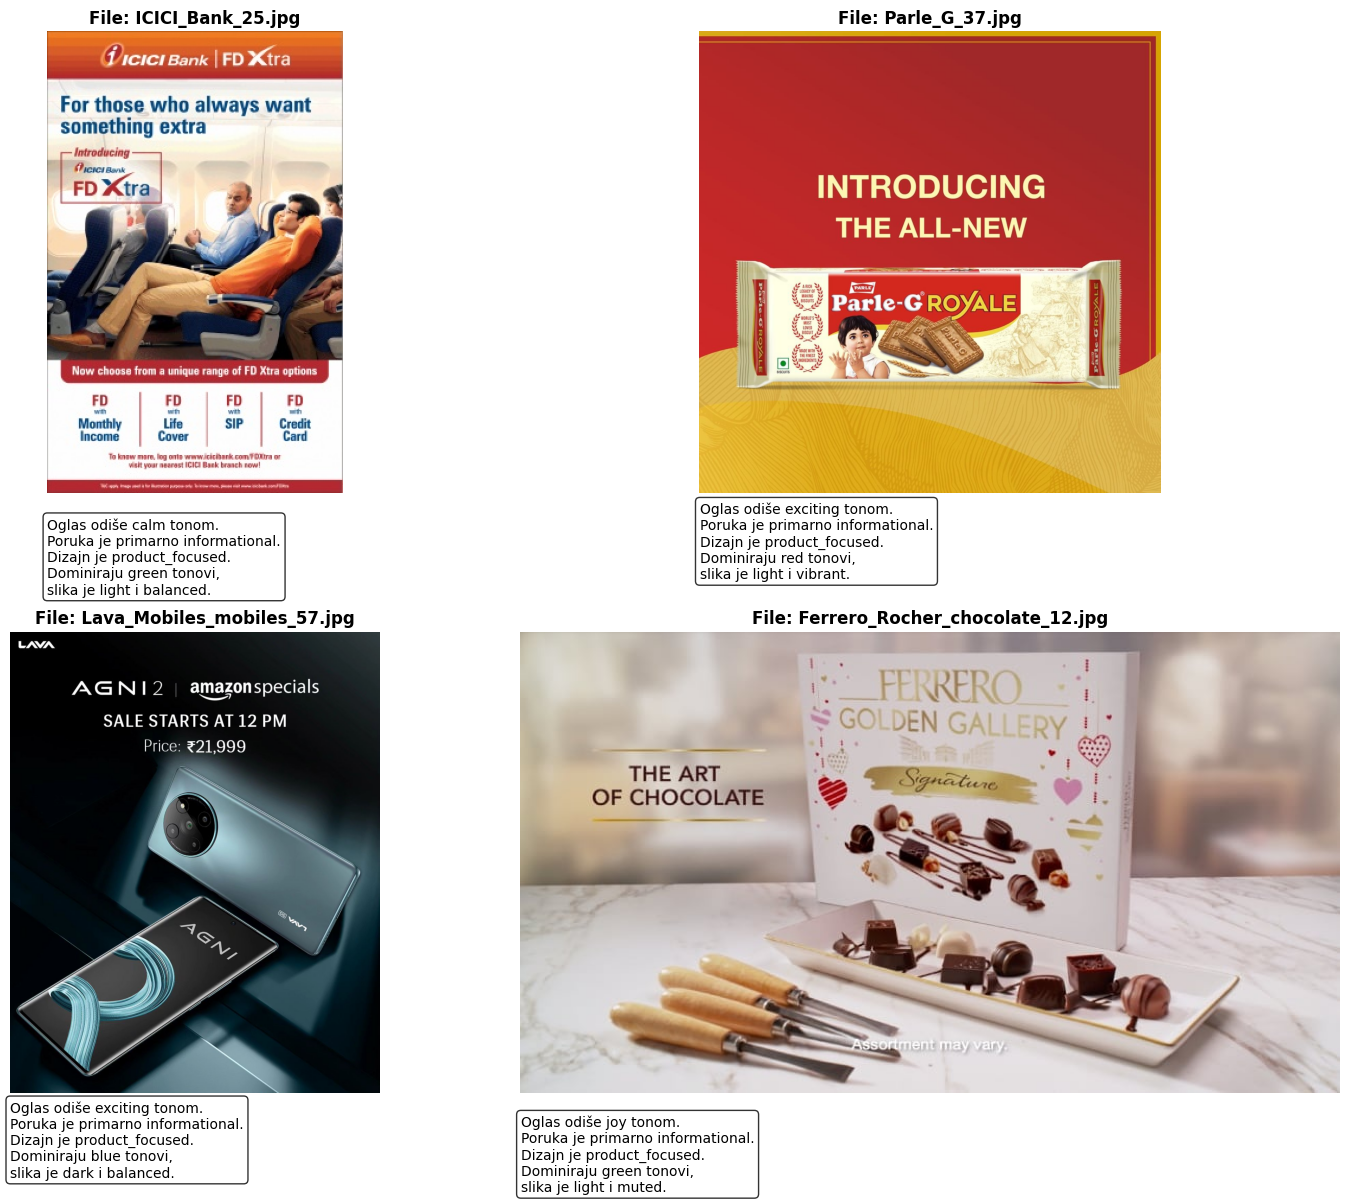

In [ ]:
if not df.empty:
    # Uzimamo prve 4 slike
    sample_df = df.head(4)

    plt.figure(figsize=(16, 12))

    for i, (index, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(extract_dir, row['filename'])
        if not os.path.exists(img_path):
            continue

        img = Image.open(img_path)

        # Dohvat featurea za ispis
        emotion = row.get('emotion_label', 'N/A')
        message = row.get('message_type', 'N/A')
        style = row.get('visual_style', 'N/A')
        hue = row.get('hue_category', 'N/A')
        brightness = row.get('brightness_category', 'N/A')
        saturation = row.get('saturation_category', 'N/A')

        # Generiranje opisa
        description = (
            f"Oglas odiše {emotion} tonom.\n"
            f"Poruka je primarno {message}.\n"
            f"Dizajn je {style}.\n"
            f"Dominiraju {hue} tonovi,\n"
            f"slika je {brightness} i {saturation}."
        )

        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"File: {row['filename']}", fontweight='bold')
        # Dodavanje teksta ispod slike
        plt.text(0, img.size[1] + 20, description, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

In [ ]:
df.columns

Index(['id', 'filename', 'group', 'image', 'emotion_joy_score',
       'emotion_calm_score', 'emotion_serious_score', 'emotion_exciting_score',
       'emotion_sad_score', 'emotion_label', 'message_informational_score',
       'message_emotional_score', 'message_symbolic_score',
       'message_persuasive_score', 'message_type', 'style_minimalist_score',
       'style_lifestyle_score', 'style_product_score', 'style_complex_score',
       'visual_style', 'num_people', 'people_present', 'people_area_ratio',
       'product_present', 'product_area_ratio', 'object_count', 'object_list',
       'dominant_element', 'text_present', 'word_count', 'char_count',
       'text_area_ratio', 'avg_font_size_proxy', 'dominant_colors',
       'brightness', 'brightness_category', 'saturation',
       'saturation_category', 'hue', 'hue_category', 'visual_impact'],
      dtype='object')

In [ ]:
df_to_save = df.drop(columns=[ 'filename', 'image', 'emotion_joy_score',
       'emotion_calm_score', 'emotion_serious_score', 'emotion_exciting_score',
       'emotion_sad_score', 'message_informational_score',
       'message_emotional_score', 'message_symbolic_score',
       'message_persuasive_score', 'style_minimalist_score',
       'style_lifestyle_score', 'style_product_score', 'style_complex_score',
       'word_count', 'char_count', 'brightness', 'saturation', 'hue',])

df_to_save.to_csv(os.path.join(drive_folder, "features_unclean.csv"), index=False)

# EDA, čišćenje

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data = pd.read_csv(os.path.join(drive_folder, "features_unclean.csv"))
data.head()

,id,group,emotion_label,message_type,visual_style,num_people,people_present,people_area_ratio,product_present,product_area_ratio,...,object_list,dominant_element,text_present,text_area_ratio,avg_font_size_proxy,dominant_colors,brightness_category,saturation_category,hue_category,visual_impact
0,0,financial_institutions,calm,informational,product_focused,3,1,0.479304,0,0.000000,...,"['person', 'person', 'person']",person,1,0.202954,13.764706,"['#eee5de', '#2c2831', '#b26651']",light,balanced,green,0.534705
1,1,food,exciting,informational,product_focused,1,1,0.018652,0,0.000000,...,['person'],person,1,0.100138,44.489509,"['#b12c28', '#d7a83b', '#ebdcbc']",light,vibrant,red,0.727336
2,2,electronics,exciting,informational,product_focused,0,0,0.000000,1,0.550735,...,"['cell phone', 'cell phone']",cell phone,1,0.078968,54.191556,"['#37474d', '#060c0f', '#748f97']",dark,balanced,blue,0.321927
3,3,food,joy,informational,product_focused,0,0,0.000000,1,0.823106,...,"['bed', 'dining table']",dining table,1,0.085437,30.833333,"['#d1c7c4', '#b19c8e', '#714f44']",light,muted,green,0.442220
4,4,body_wear,exciting,informational,product_focused,1,1,0.456454,1,0.138482,...,"['person', 'skateboard', 'skateboard']",person,1,0.120053,102.515178,"['#bac9d6', '#7494ab', '#393945']",light,balanced,blue,0.468533


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   200 non-null    int64  
 1   group                200 non-null    object 
 2   emotion_label        200 non-null    object 
 3   message_type         200 non-null    object 
 4   visual_style         200 non-null    object 
 5   num_people           200 non-null    int64  
 6   people_present       200 non-null    int64  
 7   people_area_ratio    200 non-null    float64
 8   product_present      200 non-null    int64  
 9   product_area_ratio   200 non-null    float64
 10  object_count         200 non-null    int64  
 11  object_list          200 non-null    object 
 12  dominant_element     200 non-null    object 
 13  text_present         200 non-null    int64  
 14  text_area_ratio      200 non-null    float64
 15  avg_font_size_proxy  200 non-null    flo

In [6]:
data.isnull().sum()

,0
id,0
group,0
emotion_label,0
message_type,0
visual_style,0
num_people,0
people_present,0
people_area_ratio,0
product_present,0
product_area_ratio,0


In [8]:
data.duplicated(subset=data.columns.drop('id')).sum()

np.int64(0)

Kategoričke

In [42]:
categorical_cols = data.select_dtypes(include=['object']).columns
binary_cols = ['text_present', 'people_present', 'product_present']

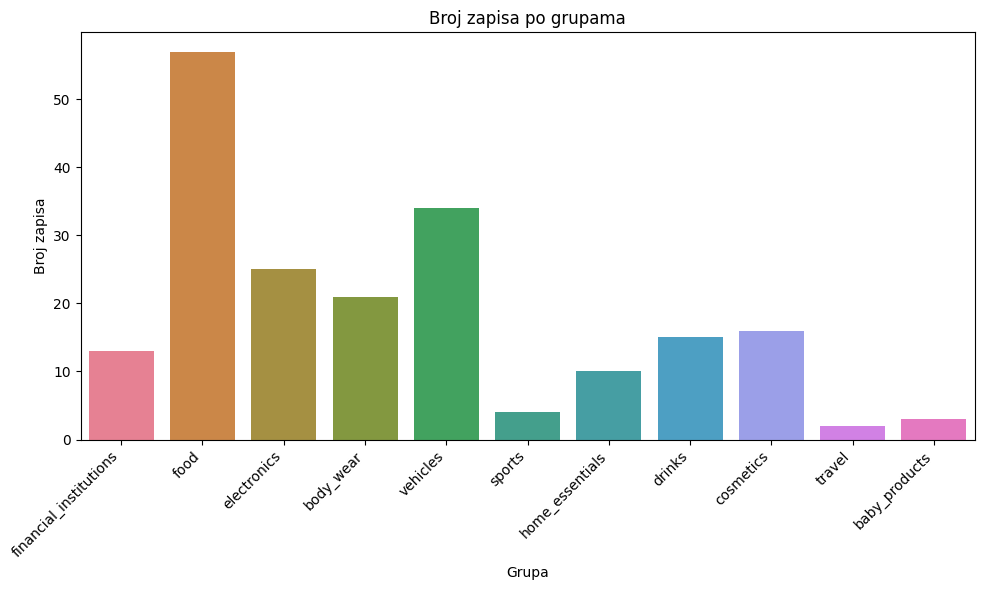

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.countplot(data=data, x='group', ax=ax, hue='group')
ax.set_title('Broj zapisa po grupama')
ax.set_xlabel('Grupa')
ax.set_ylabel('Broj zapisa')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

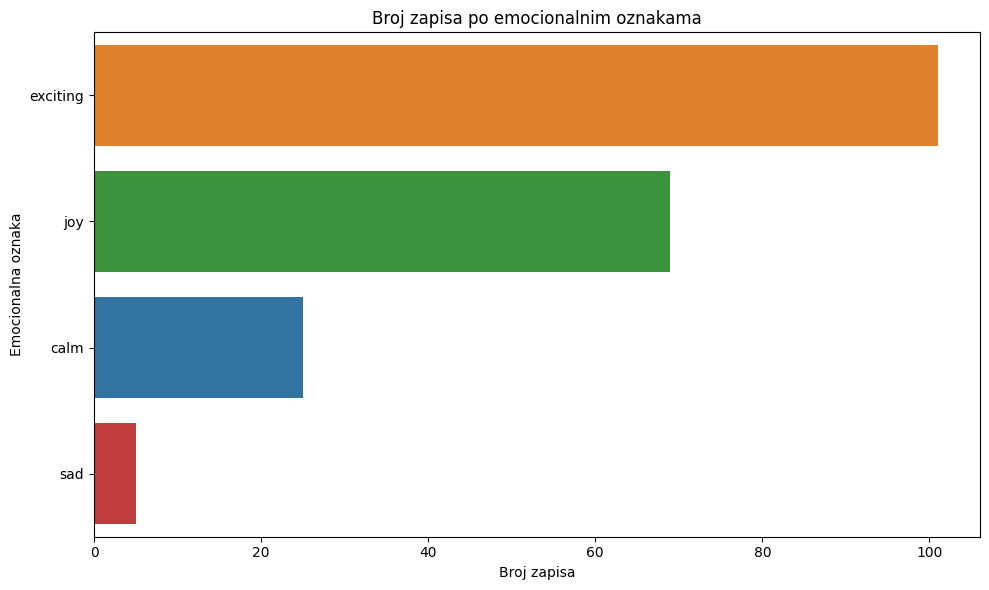

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.countplot(data=data, y='emotion_label', ax=ax, order=data['emotion_label'].value_counts().index, hue='emotion_label', legend=False)
ax.set_title('Broj zapisa po emocionalnim oznakama')
ax.set_xlabel('Broj zapisa')
ax.set_ylabel('Emocionalna oznaka')

plt.tight_layout()
plt.show()

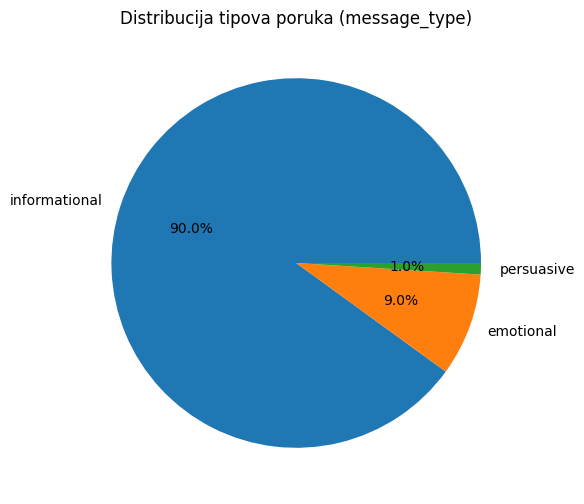

In [30]:
plt.figure(figsize=(12, 6))
message_counts = data['message_type'].value_counts()
plt.pie(message_counts, labels=message_counts.index, autopct='%1.1f%%')
plt.title('Distribucija tipova poruka (message_type)')
plt.show()

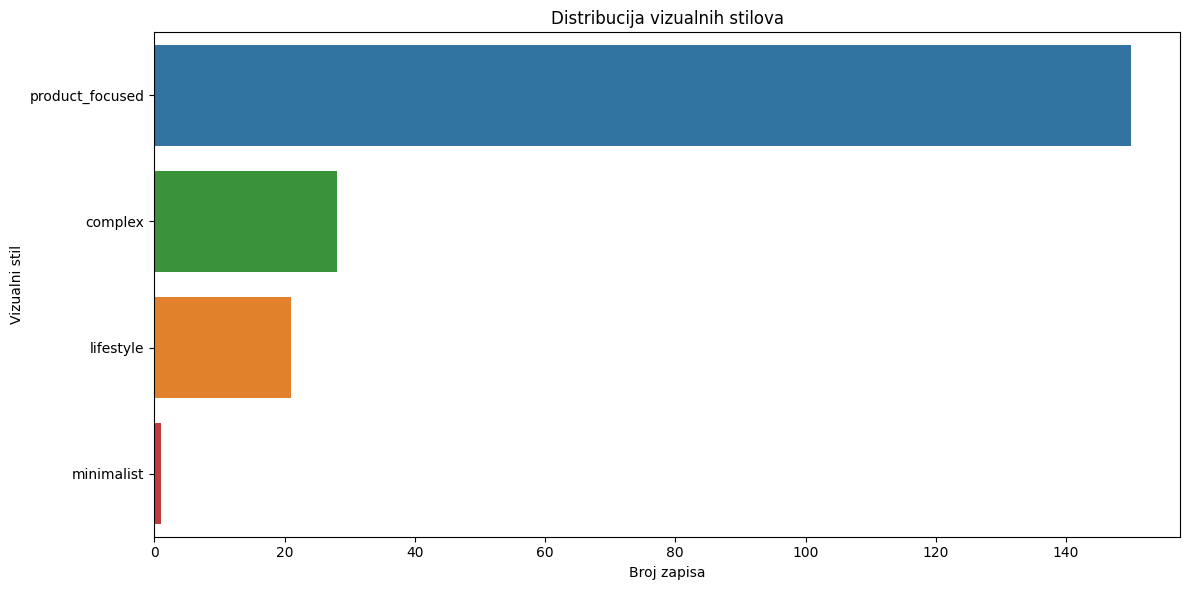

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='visual_style', order=data['visual_style'].value_counts().index, hue='visual_style')
plt.title('Distribucija vizualnih stilova')
plt.xlabel('Broj zapisa')
plt.ylabel('Vizualni stil')
plt.tight_layout()
plt.show()

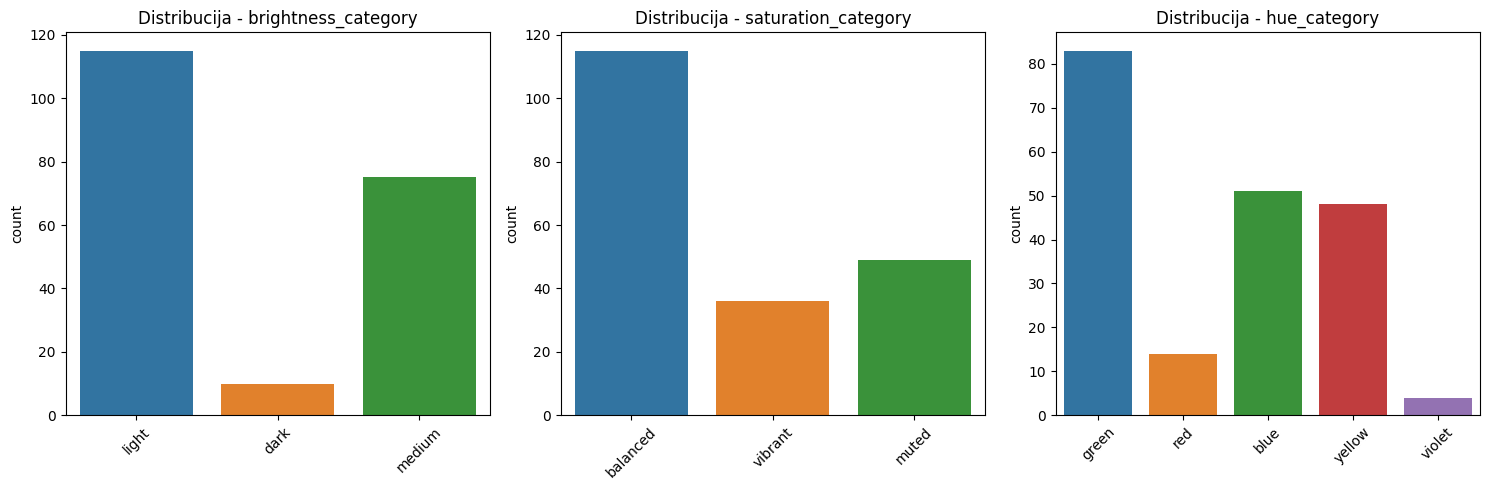

In [37]:
color_categories = ['brightness_category', 'saturation_category', 'hue_category']

fig, axes = plt.subplots(1, len(color_categories), figsize=(15, 5))

for idx, col in enumerate(color_categories):
    sns.countplot(data=data, x=col, ax=axes[idx], hue=col)
    axes[idx].set_title(f'Distribucija - {col}')
    axes[idx].set_xlabel('')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

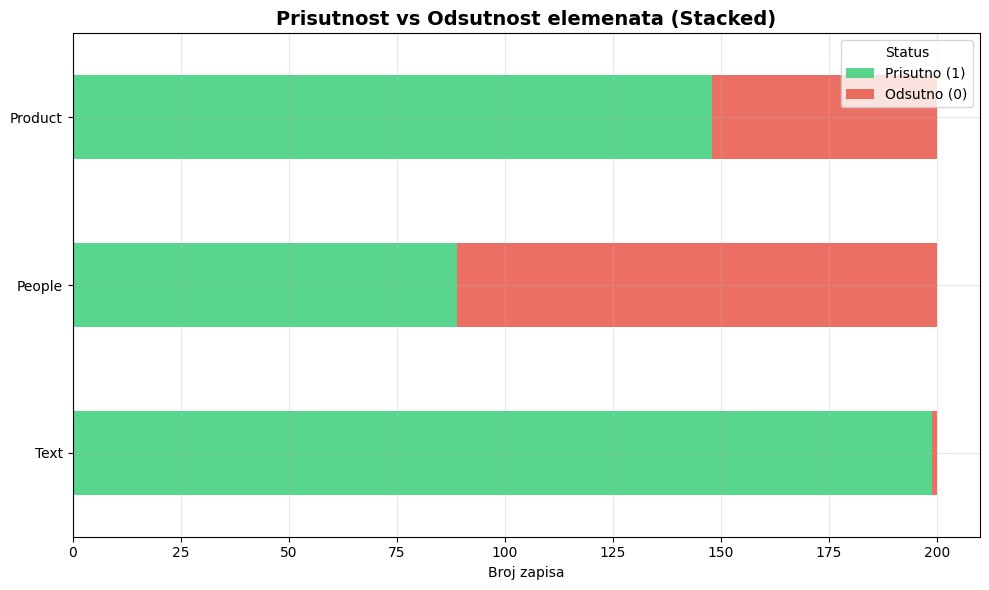

In [48]:
binary_data = []
for col in binary_cols:
    present = (data[col] == 1).sum()
    absent = (data[col] == 0).sum()
    binary_data.append({
        'Varijabla': col.replace('_present', '').replace('_', ' ').title(),
        'Prisutno (1)': present,
        'Odsutno (0)': absent
    })

binary_df = pd.DataFrame(binary_data)

fig, ax = plt.subplots(figsize=(10, 6))

binary_df.set_index('Varijabla')[['Prisutno (1)', 'Odsutno (0)']].plot(
    kind='barh', stacked=True, ax=ax, color=['#2ecc71', '#e74c3c'], alpha=0.8
)
ax.set_title('Prisutnost vs Odsutnost elemenata (Stacked)', fontsize=14, fontweight='bold')
ax.set_xlabel('Broj zapisa')
ax.set_ylabel('')
ax.legend(title='Status', loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Numeričke:

In [50]:
numeric_cols = [col for col in data.select_dtypes(include=[np.number]).columns if col not in binary_cols]
data[numeric_cols].describe()

,id,num_people,people_area_ratio,product_area_ratio,object_count,text_area_ratio,avg_font_size_proxy,visual_impact
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,99.500000,0.820000,0.188412,0.216657,2.295000,0.140590,42.012986,0.524589
std,57.879185,1.278976,0.298276,0.287680,2.026948,0.083647,27.200927,0.131229
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116637
25%,49.750000,0.000000,0.000000,0.000000,1.000000,0.081740,25.986333,0.447484
50%,99.500000,0.000000,0.000000,0.137737,2.000000,0.127875,37.917879,0.516977
75%,149.250000,1.000000,0.316037,0.309254,3.000000,0.193054,51.561421,0.601619
max,199.000000,7.000000,1.486222,1.927985,13.000000,0.621607,289.000000,0.868447


In [51]:
numeric_cols_to_plot = [col for col in numeric_cols if col != 'id']

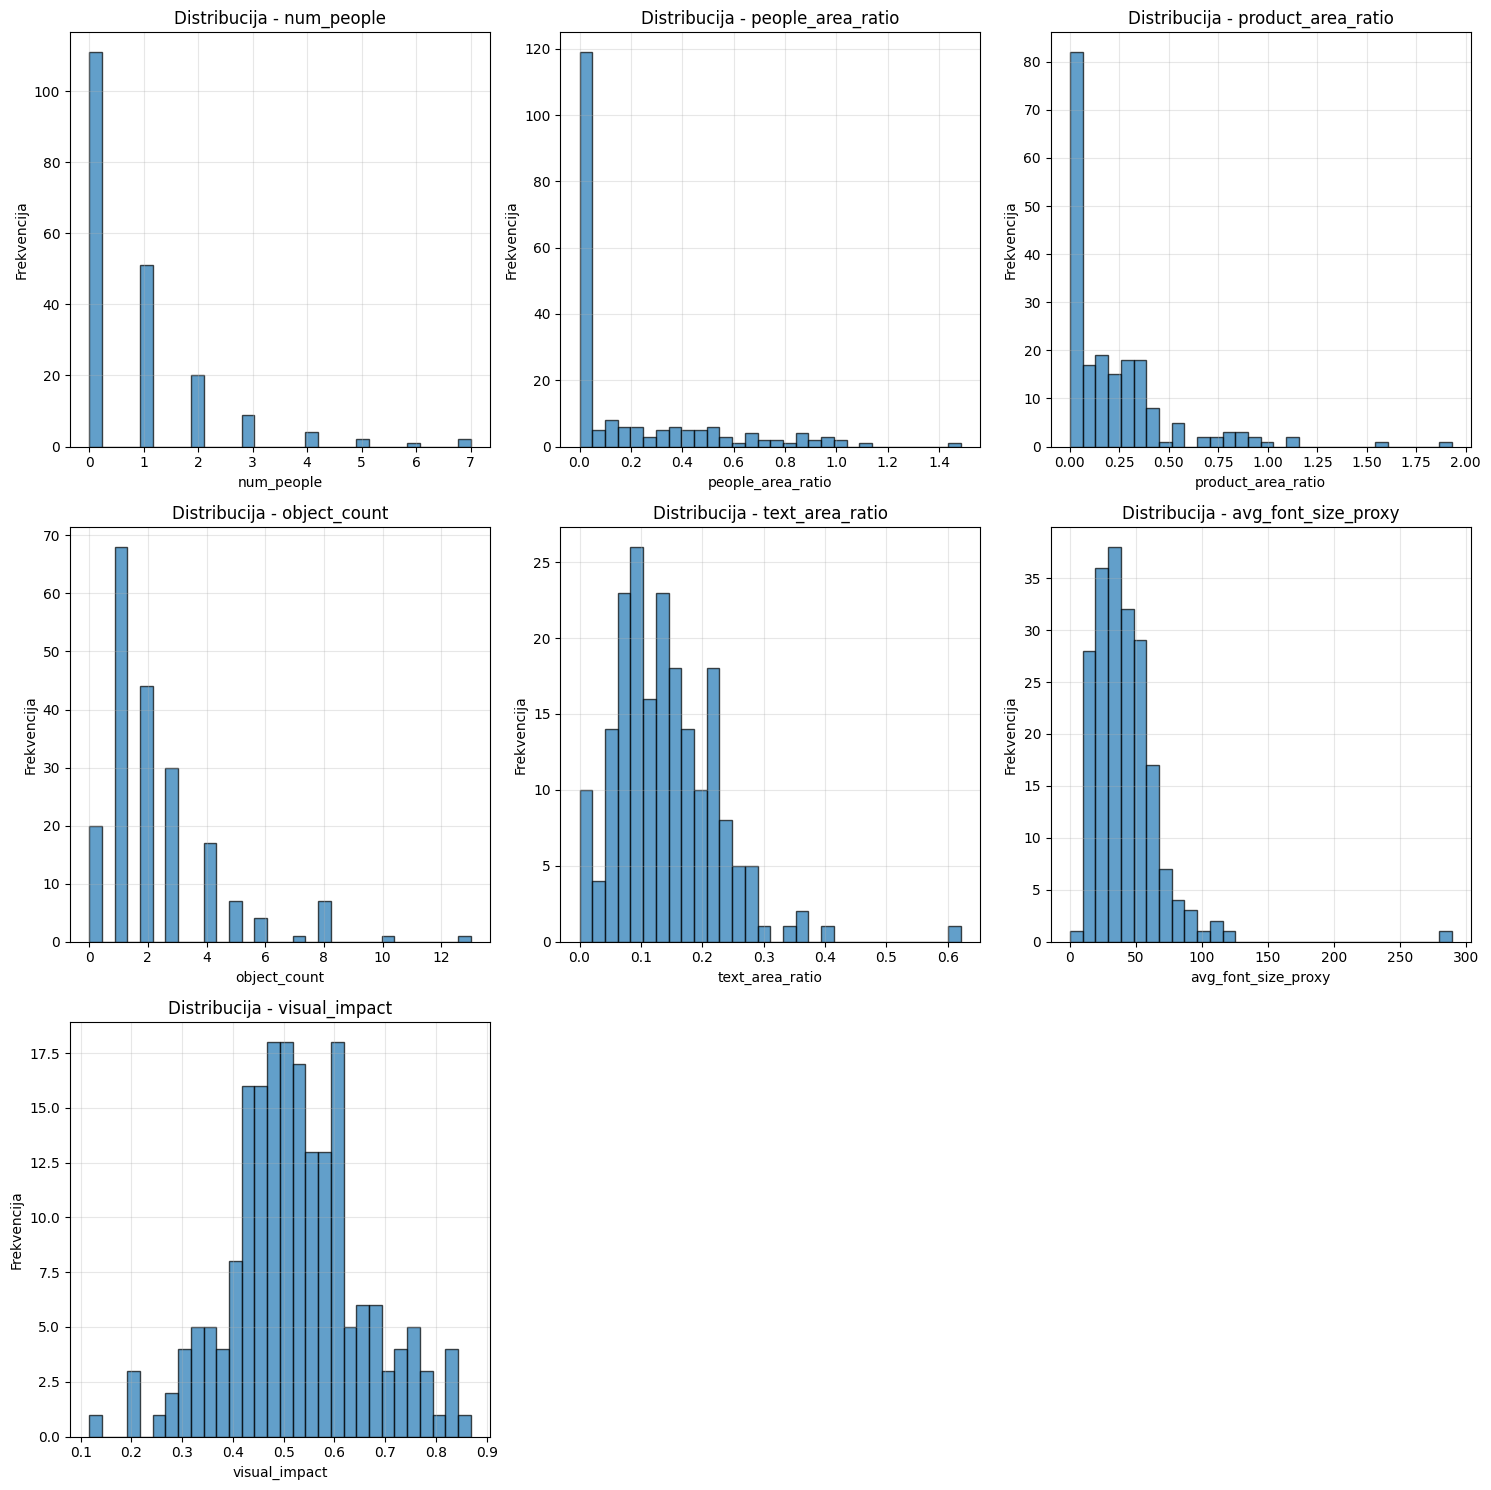

In [55]:
n_cols = 3
n_rows = (len(numeric_cols_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for idx, col in enumerate(numeric_cols_to_plot):
    if idx < len(axes):
        axes[idx].hist(data[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribucija - {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frekvencija')
        axes[idx].grid(True, alpha=0.3)

for idx in range(len(numeric_cols_to_plot), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

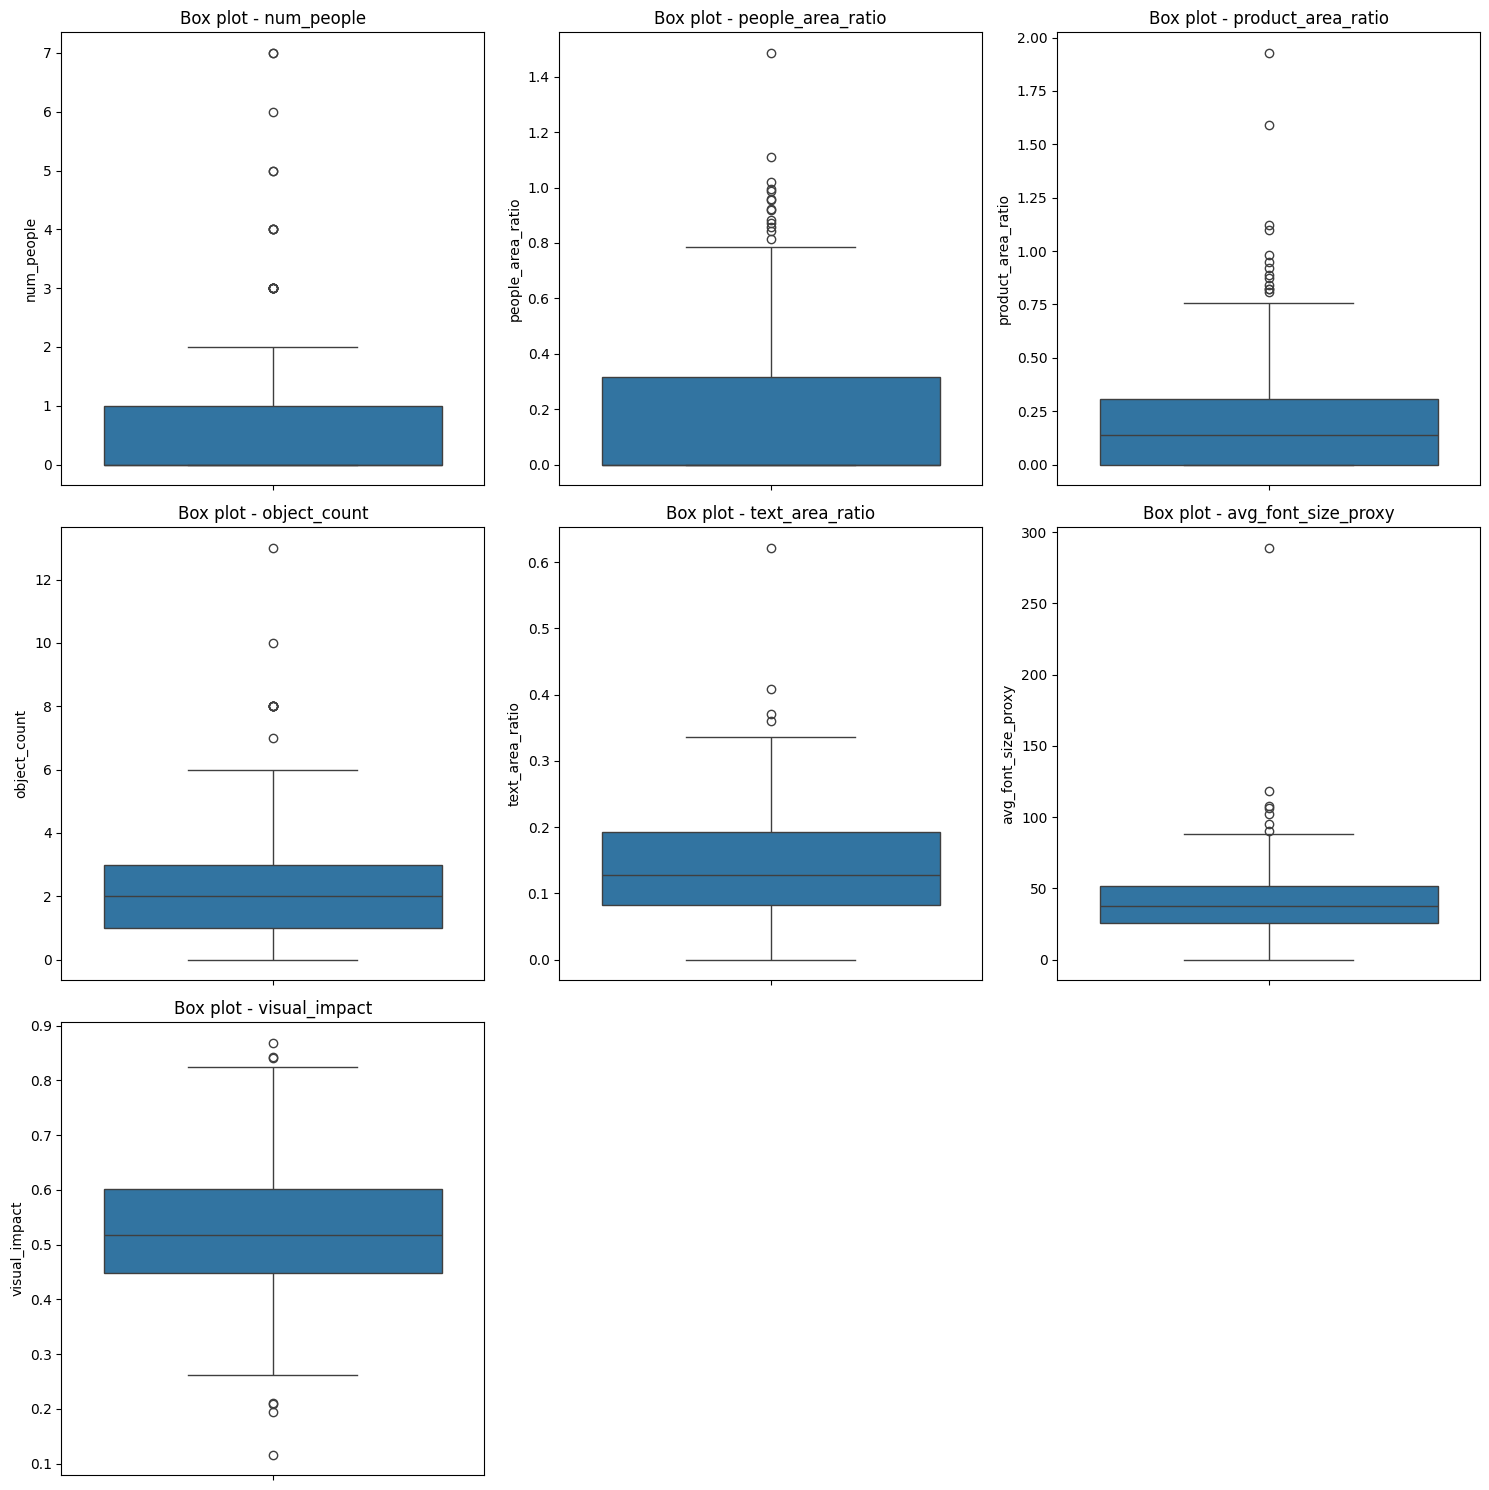

In [61]:
if numeric_cols_to_plot:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

    for idx, col in enumerate(numeric_cols_to_plot):
        if idx < len(axes):
            sns.boxplot(data=data, y=col, ax=axes[idx])
            axes[idx].set_title(f'Box plot - {col}')
            axes[idx].set_ylabel(col)

    for idx in range(len(numeric_cols_to_plot), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()


*? riješavati outliere iz ovog gore i ispod?

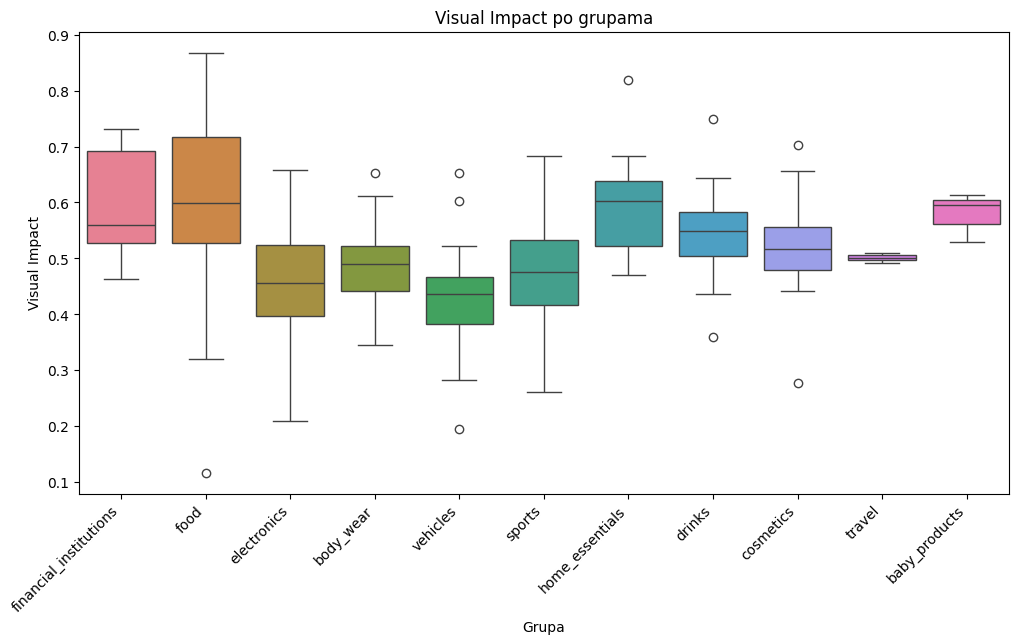

In [62]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='group', y='visual_impact', hue='group')
plt.title('Visual Impact po grupama')
plt.xlabel('Grupa')
plt.ylabel('Visual Impact')
plt.xticks(rotation=45, ha='right')
plt.show()

Korelacije

In [64]:
numeric_data = data[numeric_cols]

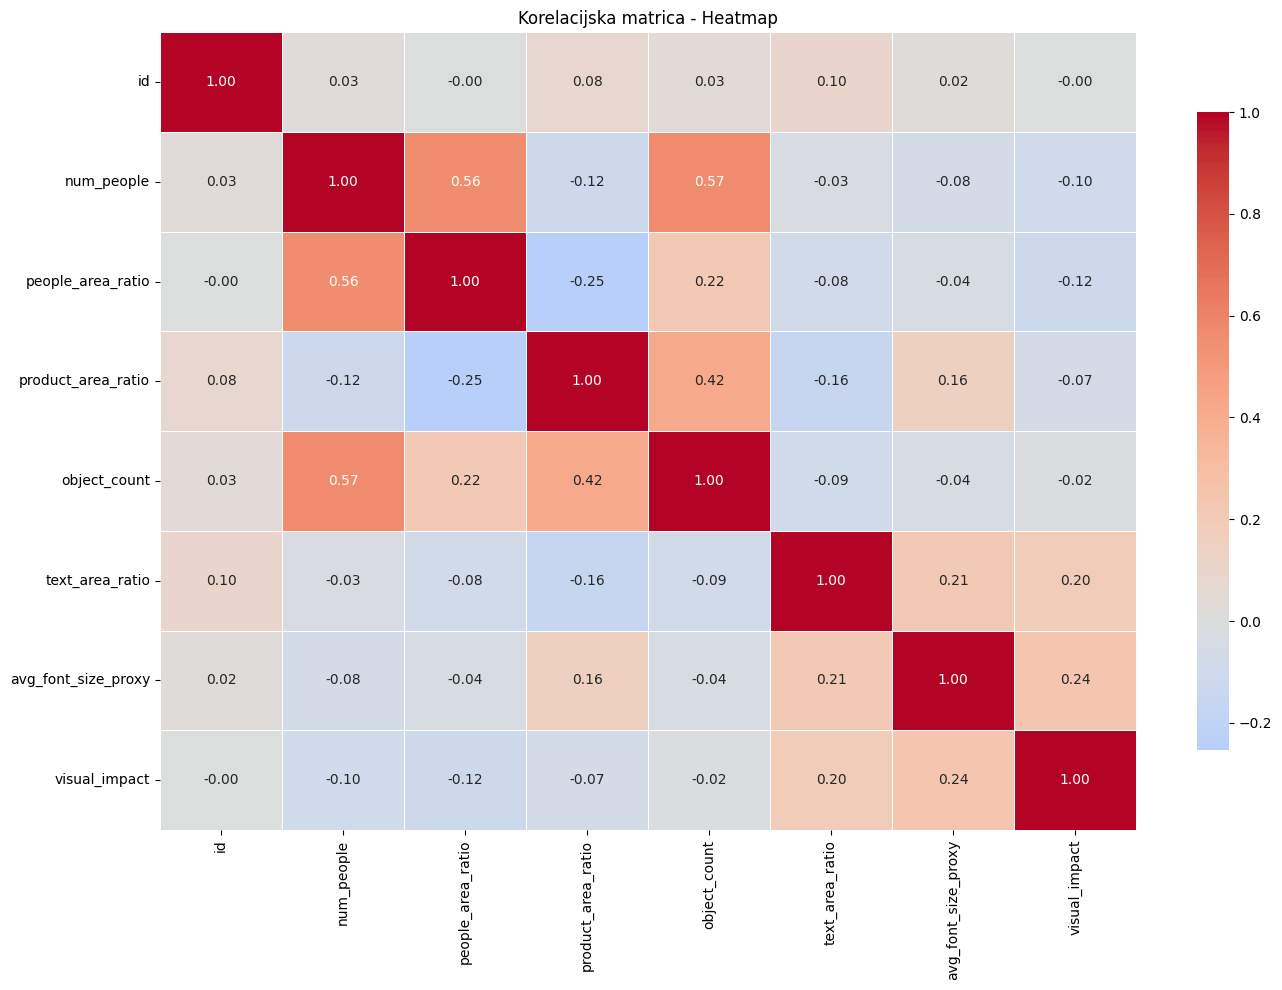

In [68]:
corr_matrix = numeric_data.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Korelacijska matrica - Heatmap')
plt.tight_layout()
plt.show()